In [1]:
import numpy as np
import pandas as pd
import sklearn.linear_model
import sklearn.metrics
import os
from sklearn.metrics import roc_auc_score

In [2]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn-v0_8') # pretty matplotlib plots


## Load Data

In [3]:
data_dir = 'data_reviews'
x_train_df = pd.read_csv(os.path.join(data_dir, 'x_train.csv'))
y_train_df = pd.read_csv(os.path.join(data_dir, 'y_train.csv'))

N, n_cols = x_train_df.shape
# print("Shape of x_train_df: (%d, %d)" % (N,n_cols))
# print("Shape of y_train_df: %s" % str(y_train_df.shape))
# x_train_df

In [4]:
# df to list
tr_text_list = x_train_df['text'].values.tolist()

In [5]:
y_train_list = y_train_df['is_positive_sentiment'].values.tolist()


## Partition sentences into words

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
vectorizer = CountVectorizer()

### How big is my vocabulary?

In [8]:
x = vectorizer.fit_transform(tr_text_list)
vocab = vectorizer.get_feature_names_out()


In [9]:
x_train_NV = x.toarray()
# N is the number of sentences, and V is the number of vocabulary

In [10]:
N = x_train_NV.shape[0]
V = x_train_NV.shape[1]

### Get the common and rare

In [11]:
x_common = []

x_col_sum = np.sum(x_train_NV, axis = 0)

np.max(x_col_sum)

1572

In [12]:
# x_col_sum.shape, x_col_sum[2701]

In [13]:
x_common = x_col_sum > N/2 # happens half of the time 
x_common_V = [int(x) for x in x_common]
x_common_V = np.array(x_common_V)

In [14]:
x_rare = x_col_sum < 10
x_rare_V = [int(x) for x in x_rare]
x_rare_V = np.array(x_rare_V)

In [15]:
# x_common_V.reshape(V, 1)

In [16]:
x_common = x_train_NV * x_common_V 
x_rare = x_train_NV * x_rare_V

### Get Normal Vocab

In [17]:
x_normal = x_train_NV * (1 - x_common_V) * (1 - x_rare_V)

In [18]:
y_train_list = np.array(y_train_list)

In [19]:
%run performance_metrics.py
%run cross_validation.py

In [20]:
M = 2

x_tr_M2 = np.random.randint(2, size=10).reshape(-1, 1)
x_va_N2 = np.random.randint(2, size=10).reshape(-1, 1)
y_tr_M = np.random.randint(2, size=10)
y_va_N = np.random.randint(2, size=10)

## Cross Validation

In [21]:
%run binary_metrics.py
%run proba_metrics.py

In [22]:
K = 3 # num folds of CV
random_state = 1234

train_error_per_fold = np.zeros(K, dtype=np.float32)
test_error_per_fold = np.zeros(K, dtype=np.float32)

N = x_normal.shape[0]
# TODO define the folds here by calling your function
# e.g. ... = make_train_and_test_row_ids_for_n_fold_cv(...)
train_ids, test_ids = make_train_and_test_row_ids_for_n_fold_cv(
    N, K, random_state)

len(train_ids[0]), len(test_ids[0])

(1599, 801)

In [23]:
y_list = y_train_list

## normalize the data

In [24]:
# partition the data into train and test

x_tr, y_tr = list(), list()
y_va, x_va = list(), list()


for i in range(len(train_ids)):
    x_tr.append(x_normal[train_ids[i]])
    y_tr.append(y_list[train_ids[i]])

for i in range(len(test_ids)):
    x_va.append(x_normal[test_ids[i]])
    y_va.append(y_list[test_ids[i]])


In [25]:
C_grid = np.logspace(4, 9, 5)

In [26]:
cv_tr_bce_list = list()
cv_va_bce_list = list()
cv_te_bce_list = list()

model_list = list()
tr_bce_list_for_each_C = list()
va_bce_list_for_each_C = list()
# idx = 0
for C in C_grid:

    model_F3_list = list()

    # Allocate lists for storing BCE metrics
    tr_bce_list = list()
    va_bce_list = list()
    te_bce_list = list()

    # Allocate lists for storing ERROR RATE metrics
    tr_err_list = list()
    va_err_list = list()
    te_err_list = list()

    # idx = idx + 1
    for i in range(K):
        xtr = x_tr[i]
        ytr = y_tr[i]
        xva = x_va[i]
        yva = y_va[i]

        lr_F3 = sklearn.linear_model.LogisticRegression(C = C, penalty = 'l2', solver='lbfgs', max_iter=2000) # TODO fixme
        lr_F3.fit(xtr, ytr) # TODO fixme

        model_F3_list.append(lr_F3)

        yproba1_tr_M = lr_F3.predict_proba(xtr)[:,1] # The probability of predicting class 1 on the training set
        yproba1_va_N = lr_F3.predict_proba(xva)[:,1] # The probability of predicting class 1 on the validation set

        # Compute error rate aka zero-one loss
        my_tr_err = sklearn.metrics.zero_one_loss(ytr, yproba1_tr_M >= 0.5)
        my_va_err = sklearn.metrics.zero_one_loss(yva, yproba1_va_N >= 0.5)
        tr_err_list.append(my_tr_err)
        va_err_list.append(my_va_err)

        # TODO: using the calc_mean_binary_cross_entropy_from_probas() function from above:
        # Part c: calculate the binary cross entropy (bce) on the training set
        # Part d: calculate the binary cross entropy (bce) on the validation set
        my_tr_bce = calc_mean_binary_cross_entropy_from_probas(ytr, yproba1_tr_M) # TODO fixme
        my_va_bce = calc_mean_binary_cross_entropy_from_probas(yva, yproba1_va_N) # TODO fixme
        # Save bce for future selection on Models.
        tr_bce_list.append(my_tr_bce) 
        va_bce_list.append(my_va_bce)
    
    tr_bce_list_for_each_C.append(tr_bce_list)
    va_bce_list_for_each_C.append(va_bce_list)
    
    model_list.append(model_F3_list)
    
    # best_C_idx = np.argmin(va_bce_list)
    # best_C__lrF3 = C_grid[best_C_idx]
    
    cv_tr_bce_list.append((sum(tr_bce_list)/len(tr_bce_list)))
    cv_va_bce_list.append((sum(va_bce_list)/len(va_bce_list)))
    


In [27]:
best_C_index = np.argmin(cv_va_bce_list)

In [28]:
best_fold_in_C = np.argmin(va_bce_list_for_each_C[best_C_index])

In [29]:
best_C__lr = C_grid[best_C_index]
best_lr = model_list[best_C_index][best_fold_in_C]

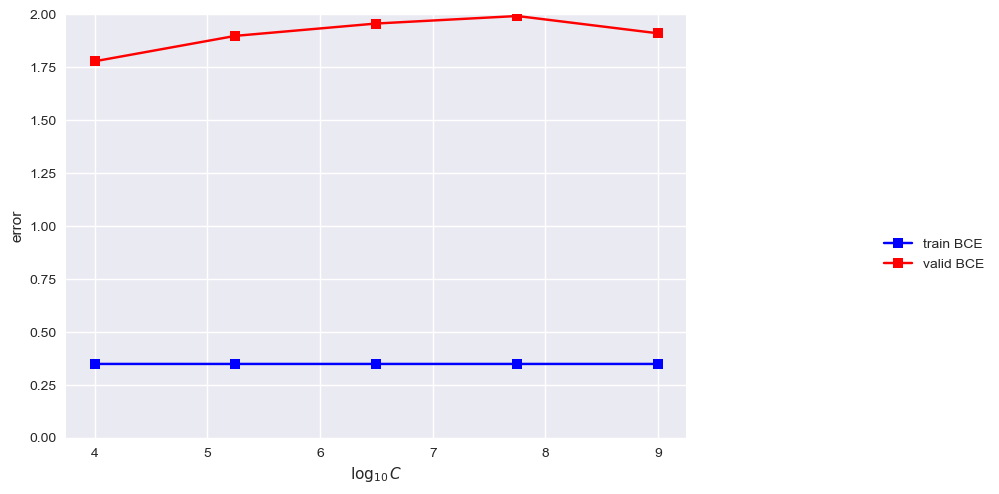

In [30]:
plt.plot(np.log10(C_grid), cv_tr_bce_list, 'bs-', label='train BCE')
plt.plot(np.log10(C_grid), cv_va_bce_list, 'rs-', label='valid BCE')

# plt.plot(np.log10(C_grid), tr_err_list, 'b:', label='train err')
# plt.plot(np.log10(C_grid), va_err_list, 'r:', label='valid err')

plt.ylabel('error')
plt.xlabel("$\log_{10} C$");
plt.legend(bbox_to_anchor=(1.5, 0.5)) # make legend outside plot
plt.ylim([0, 2]);

In [31]:
print("Best model has coefficient values:")
print(best_lr.coef_)

Best model has coefficient values:
[[0.         2.19143581 0.         ... 0.         0.         0.        ]]


In [32]:
prng = np.random.RandomState(101)

bestlr_yproba1_tr = best_lr.predict_proba(x_tr[best_fold_in_C])[:,1] # TODO fixme
bestlr_yproba1_va = best_lr.predict_proba(x_va[best_fold_in_C])[:,1] # TODO fixme

In [33]:
# bestlr_yproba1_va.shape
# y_va[best_fold_in_C].shape

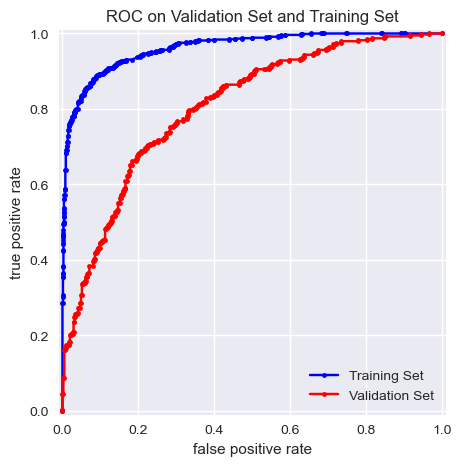

In [34]:
# Follow the instruction of HW2 and produce Figure 1 for your report:
plt.subplots(nrows=1, ncols=1, figsize=(5,5));

# TODO Use provided data and predictions on the Validation set
# Produce the ROC Curve utilizing `sklearn.metrics.roc_curve' within plt defined above.
# To start, read the official Document and examples of 'sklearn.metrics.roc_curve'. 
va_fpr, va_tpr, va_thresholds = sklearn.metrics.roc_curve(y_va[best_fold_in_C], bestlr_yproba1_va)
tr_fpr, tr_tpr, tr_thresholds = sklearn.metrics.roc_curve(y_tr[best_fold_in_C], bestlr_yproba1_tr)

# Read HW2 instructions carefully for plot style (line type, line color, etc.)

plt.plot(tr_fpr, tr_tpr, 'b.-', label = "Training Set" )
plt.plot(va_fpr, va_tpr, 'r.-', label = "Validation Set" )
plt.title("ROC on Validation Set and Training Set");
plt.xlabel('false positive rate');
plt.ylabel('true positive rate');
plt.legend(loc='lower right');
B = 0.01
plt.xlim([0 - B, 1 + B]);
plt.ylim([0 - B, 1 + B]);

## Confusion Matrix on the best C/fold

In [35]:
import threshold_selection
from confusion_matrix import calc_confusion_matrix_for_probas_and_threshold

In [36]:
best_thr_default = 0.5

print(sklearn.metrics.confusion_matrix(y_va[best_fold_in_C], bestlr_yproba1_va >= best_thr_default))

thresh_grid, perf_dict = threshold_selection.compute_perf_metrics_across_thresholds(y_va[best_fold_in_C], bestlr_yproba1_va, [best_thr_default])

tpr = perf_dict['tpr'][0]# TODO fixme
ppv = perf_dict['ppv'][0] # TODO fixme

print(f"chosen thr = {best_thr_default :.4f}, tpr = {tpr :.4f}, ppv = {ppv :.4f},")

[[292 118]
 [ 97 294]]
chosen thr = 0.5000, tpr = 0.7519, ppv = 0.7136,


## Area Under ROC Curve

In [37]:
roc_auc_score(y_va[best_fold_in_C],bestlr_yproba1_va, max_fpr = 0.98)

0.8060418103989146

## read the test file into vocab matrix

In [ ]:
# x_test_df = pd.read_csv(os.path.join(data_dir, 'x_test.csv'))
# x_test_df.shape

In [ ]:
te_text_list = x_test_df['text'].values.tolist()
len(te_text_list)

In [ ]:
vec = CountVectorizer(vocabulary = vocab)
t = vec.fit_transform(te_text_list)
t

In [ ]:
te_array = t.toarray()
te_array.shape

In [ ]:
y_te_proba = best_lr.predict_proba(te_array)[:,1]
y_te_proba

In [ ]:
y_te_proba.shape, y_te_proba[5]

In [ ]:
for i in range(y_te_proba.shape[0]):
    if y_te_proba[i] >= 0.5: 
        y_te_proba[i] = 1
    else:
        y_te_proba[i] = 0

In [ ]:
# np.savetxt('out4.txt', y_te_proba, delimiter=' ', fmt='% 3d')


In [ ]:
# # remove punctuation in the text
# def rm_punc(text_list):
#     puncs = '!@#$%^&*()_+-={}[]:;|<>,.?/"\''
#     clean_text_list = []
#     for text in text_list:
#         clean_text = ""
#         for char in text:
#             if char not in puncs:
#                 clean_text += char.lower()
#         clean_text_list.append(clean_text)
#     return clean_text_list

# clean_tr_text = rm_punc(tr_text_list)
# clean_tr_text[0]

In [ ]:
# # partition the data
# words_list = []
# for text in clean_tr_text:
#     words_list.append(text.split())
    
# words_list[0]